# Customer Segmentation: Small Business Owners in the United States

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Prepare Data

### Import 

In [2]:
# import data
df = pd.read_csv("Data/scfp2019excel.zip")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


### Export

In [4]:
# calculate proportion of business owners
prop_biz_owners = df["HBUS"].value_counts(normalize=True)[1]
print("proportion of business owners in df:", prop_biz_owners)

proportion of business owners in df: 0.2740176562229531


In [5]:
# create replacement dictionary
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

# create dataframe of income categories for business/non-business owners
df_inccat = (
    df['INCCAT']
    .replace(inccat_dict)
    .groupby(df['HBUS'])
    .value_counts(normalize=True)
    .rename('frequency')
    .to_frame()
    .reset_index()
)

# display dataframe
df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


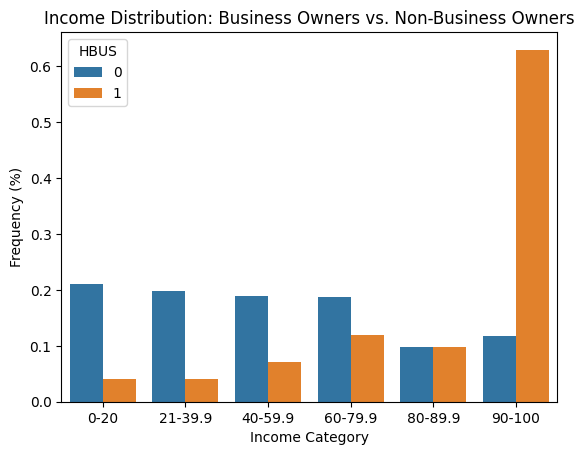

In [6]:
# Create bar chart of `df_inccat`
sns.barplot(
    x='INCCAT',
    y = 'frequency',
    hue = 'HBUS',
    data = df_inccat,
    order = inccat_dict.values()
)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners");


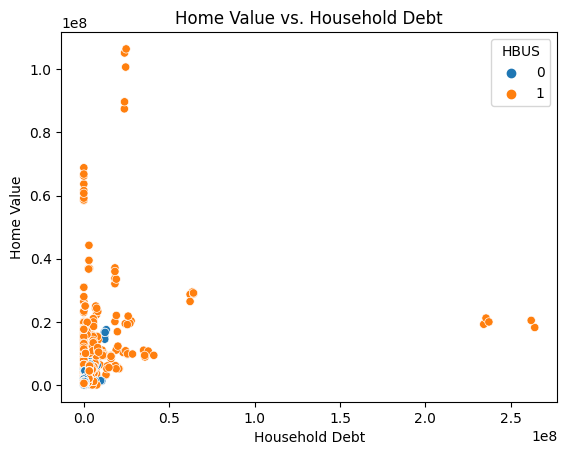

In [7]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x = 'DEBT',
    y = 'HOUSES',
    hue = 'HBUS',
    data = df
)
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt");

### Split

## Build Model

### Iterate

## Communicate